<a href="https://colab.research.google.com/github/ritwiks9635/Transformer_Model/blob/main/Image_classification_with_Swin_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image classification with Swin Transformers**

In [ ]:
! pip install keras --upgrade

In [2]:
import keras
import numpy as np
import tensorflow as tf
from keras import ops
from keras import layers
import matplotlib.pyplot as plt

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(45000, 32, 32, 3) (45000, 100)
(10000, 32, 32, 3) (10000, 100)


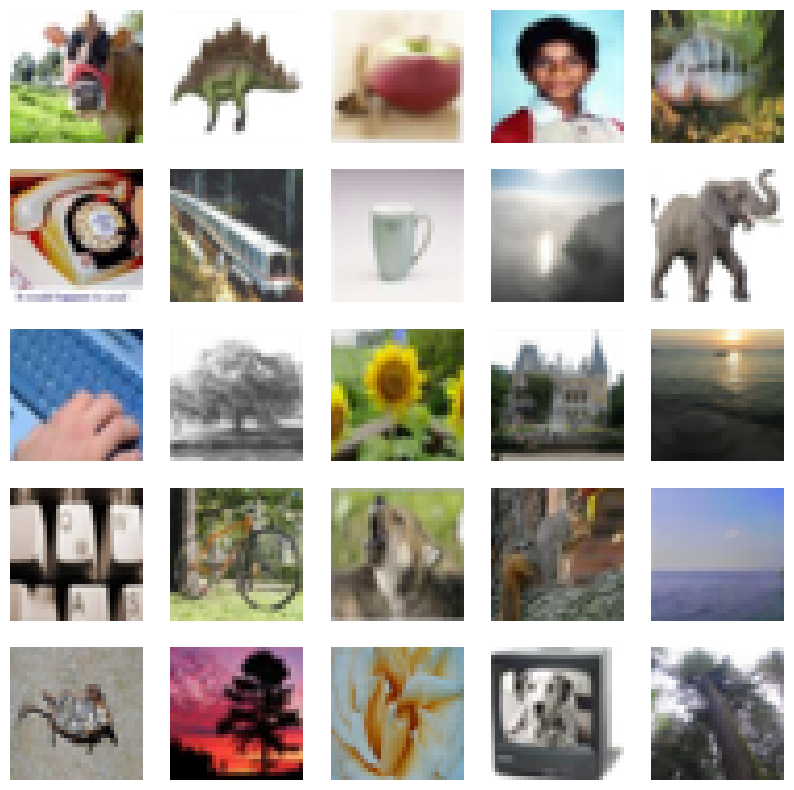

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

num_train_split = int(len(x_train) * (1 - validation_split))
x_train, x_val = np.split(x_train, [num_train_split])
y_train, y_val = np.split(y_train, [num_train_split])
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.grid(False)
    plt.axis("off")
plt.show()

#**Helper functions**
We create two helper functions to help us get a sequence of patches from the image, merge patches, and apply dropout.

In [5]:
def window_partition(image, window_size):
    _, height, width, channel = image.shape
    patch_y = height // window_size
    patch_x = width // window_size
    x = ops.reshape(image, (-1, patch_y, window_size, patch_x, window_size, channel))
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channel))
    return windows

def window_reverse(windows, window_size, height, width, channel):
    patch_y = height // window_size
    patch_x = width // window_size
    x = ops.reshape(windows, (-1, patch_y, patch_x, window_size,  window_size,  channel))
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    image = ops.reshape(x, (-1, height, width, channel))
    return image

#**Window based multi-head self-attention**
Usually Transformers perform global self-attention, where the relationships between a token and all other tokens are computed. The global computation leads to quadratic complexity with respect to the number of tokens. Here, as the original paper suggests, we compute self-attention within local windows, in a non-overlapping manner. Global self-attention leads to quadratic computational complexity in the number of patches, whereas window-based self-attention leads to linear complexity and is easily scalable.

In [6]:
class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias = True, dropout_rate = 0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias = qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)
        num_window_elements = (2 * self.window_size[0] - 1) * (            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

#**The complete Swin Transformer model**
Finally, we put together the complete Swin Transformer by replacing the standard multi-head attention (MHA) with shifted windows attention. As suggested in the original paper, we create a model comprising of a shifted window-based MHA layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying LayerNormalization before each MSA layer and each MLP, and a residual connection after each of these layers.

In [7]:
class SwinTransformer(layers.Layer):
    def __init__(self, dim, num_patches, num_heads, window_size = 7, shift_size = 0, num_mlp = 1024, qkv_bias = True, dropout_rate = 0.0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp

        self.norm1 = layers.LayerNormalization(epsilon = 1e-5)
        self.attn = WindowAttention(dim = self.dim, window_size = (self.window_size, self.window_size), num_heads = self.num_heads, qkv_bias = qkv_bias, dropout_rate = dropout_rate)
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon = 1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(tf.nn.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate)
            ])

        if min(self.num_patches) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patches)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patches
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patches
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

#**Extract and embed patches**
We first create 3 layers to help us extract, embed and merge patches from the images on top of which we will later use the Swin Transformer class we built.

In [8]:
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = (1, patch_size[0], patch_size[1], 1),
        strides = (1, patch_size[0], patch_size[1], 1),
        rates = (1, 1, 1, 1),
        padding = "VALID")

    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim = num_patch, output_dim = embed_dim)

    def call(self, patch):
        pos = np.arange(start = 0, stop = self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)



class PatchMerging(layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias = False)


    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis = -1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4*C))
        return self.linear_trans(x)

In [9]:
def augment(x):
    x = tf.image.random_crop(x, (image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x

dataset_train = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y : (augment(x), y))
    .batch(batch_size)
    .map(lambda x, y : (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE))


dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size)
    .map(lambda x, y : (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size)
    .map(lambda x, y : (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE))

In [10]:
inputs = keras.Input(shape = (256, 12))

x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(inputs)

x = SwinTransformer(
    dim = embed_dim,
    num_patches = (num_patch_x, num_patch_y),
    num_heads = num_heads,
    window_size = window_size,
    shift_size = 0,
    num_mlp = num_mlp,
    qkv_bias = qkv_bias,
    dropout_rate = dropout_rate)(x)

x = SwinTransformer(
    dim = embed_dim,
    num_patches = (num_patch_x, num_patch_y),
    num_heads = num_heads,
    window_size = window_size,
    shift_size = shift_size,
    num_mlp = num_mlp,
    qkv_bias = qkv_bias,
    dropout_rate = dropout_rate)(x)

x = PatchMerging((num_patch_x, num_patch_y), embed_dim = embed_dim)(x)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes, activation = "softmax")(x)

model = keras.Model(inputs, outputs)

In [11]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate, weight_decay = weight_decay),
    loss = keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing),
    metrics = [
        keras.metrics.CategoricalAccuracy(name = "accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name = "top_5_accuracy")
        ])


history = model.fit(dataset_train, batch_size = batch_size, epochs = num_epochs, validation_data = dataset_val)

Epoch 1/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 125s 188ms/step - accuracy: 0.0573 - loss: 4.3633 - top_5_accuracy: 0.1916 - val_accuracy: 0.1552 - val_loss: 3.7865 - val_top_5_accuracy: 0.4018
Epoch 2/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.1699 - loss: 3.6964 - top_5_accuracy: 0.4337 - val_accuracy: 0.2070 - val_loss: 3.5327 - val_top_5_accuracy: 0.4994
Epoch 3/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.2186 - loss: 3.4649 - top_5_accuracy: 0.5160 - val_accuracy: 0.2450 - val_loss: 3.3628 - val_top_5_accuracy: 0.5494
Epoch 4/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.2563 - loss: 3.3067 - top_5_accuracy: 0.5639 - val_accuracy: 0.2748 - val_loss: 3.2619 - val_top_5_accuracy: 0.5874
Epoch 5/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.2855 - loss: 3.1945 - top_5_accuracy: 0.5997 - val_accuracy: 0.2972 - val_loss: 3.1737 - val_top_5_accuracy: 0.6096
Epoch 6/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.3074 - los

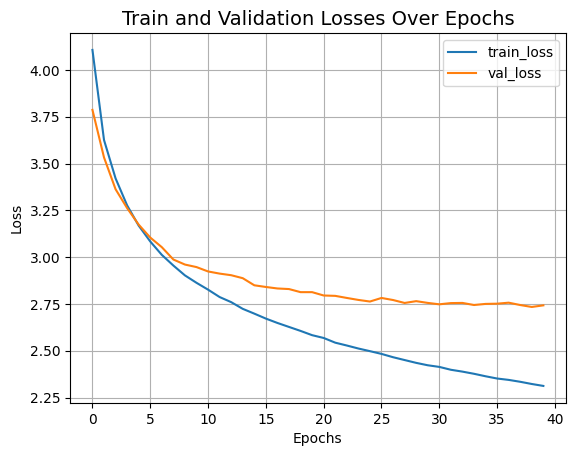

In [12]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.4493 - loss: 2.6750 - top_5_accuracy: 0.7589
Test loss: 2.66
Test accuracy: 45.48%
Test top 5 accuracy: 75.88%


The Swin Transformer model we just trained has just 152K parameters, and it gets us to ~75% test top-5 accuracy within just 40 epochs without any signs of overfitting as well as seen in above graph. This means we can train this network for longer (perhaps with a bit more regularization) and obtain even better performance. This performance can further be improved by additional techniques like cosine decay learning rate schedule, other data augmentation techniques.